Ten skrypt służy wstępnej analizy i filtracji danych

------
### POTRZEBNE FUNKCJE
------

In [1]:
# załadowanie potrzebnych paczek 
library(Seurat)
library(data.table)
library(dplyr)
library(ggplot2)
library(patchwork) 

Ładowanie wymaganego pakietu: SeuratObject

Ładowanie wymaganego pakietu: sp

Warning message:
"pakiet 'sp' został zbudowany w wersji R 4.3.3"

Dołączanie pakietu: 'SeuratObject'


Następujące obiekty zostały zakryte z 'package:base':

    intersect, t



Dołączanie pakietu: 'dplyr'


Następujące obiekty zostały zakryte z 'package:data.table':

    between, first, last


Następujące obiekty zostały zakryte z 'package:stats':

    filter, lag


Następujące obiekty zostały zakryte z 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"pakiet 'patchwork' został zbudowany w wersji R 4.3.3"


In [2]:
# funkcja pomocnicza do kalkulacji statystyk 
print_seurat_stats <- function(seurat_object) {
  if (is.null(seurat_object) || length(seurat_object) == 0) {
    cat("The Seurat object is empty or NULL.\n")
    return(NULL)
  }

  remaining_cells <- ncol(seurat_object)
  remaining_genes <- nrow(seurat_object)
  cat("Number of cells:", remaining_cells, "\n")
  cat("Number of genes:", remaining_genes, "\n")
}

In [3]:
# funkcja do załadowania danych
process_seurat_sample <- function(data_dir, assignment_table_path) {
  data <- Read10X(data.dir = data_dir)
  seurat_object_temp <- CreateSeuratObject(counts = data$`Gene Expression`)
  seurat_object_temp[["CMO"]] <- CreateAssayObject(counts = data$`Multiplexing Capture`)
  seurat_object <- seurat_object_temp
  cells <- fread(assignment_table_path, select = c("Barcode"))

  seurat_object_use <- subset(seurat_object, cells = cells$Barcode)

  print_seurat_stats(seurat_object_use)
  seurat_object_use[["percent.mt"]] <- PercentageFeatureSet(seurat_object_use, pattern = "^MT-")
  return(seurat_object_use)
}

In [11]:
plot_with_threshold <- function(seurat_obj, features, threshold_list = NULL, titles = NULL, x_labels = NULL) {
  plots <- list()
  options(repr.plot.width = 12, repr.plot.height = 5)
  for (i in seq_along(features)) {
    feature <- features[i]
    p <- VlnPlot(seurat_obj, features = feature, pt.size = 0.1) + NoLegend()

    if (!is.null(threshold_list) && length(threshold_list) >= i && !is.na(threshold_list[i])) {
      p <- p + geom_hline(yintercept = threshold_list[i], color = "red", linetype = "dashed")
    }

    if (!is.null(titles) && length(titles) >= i && !is.na(titles[i])) {
      p <- p + ggtitle(titles[i])
    }

    if (!is.null(x_labels) && length(x_labels) >= i && !is.na(x_labels[i])) {
      p <- p + xlab(x_labels[i])
    }

    plots[[i]] <- p
  }
  
  wrap_plots(plots, ncol = 3)
}

In [5]:
# filtrowanie
filter_seurat_object <- function(seurat_obj, threshold_cells, threshold_mt){
    DefaultAssay(seurat_obj) <- "RNA"
    seurat_obj <- subset(seurat_obj, subset = nFeature_RNA > threshold_cells & nCount_RNA > threshold_cells & percent.mt < threshold_mt )
    return(seurat_obj)
}

In [6]:
plot_qc_violin <- function(seurat_object, group.by = "hash.ID", fill_colors = NULL) {
  if (is.null(fill_colors)) {
    fill_colors <- c(
      "Hash18" = "#800000",
      "Hash19" = "#F0E68C",
      "Hash23" = "#7F7F7F",
      "Hash24" = "#008080"
    )
  }
  options(repr.plot.width = 12, repr.plot.height = 5)
  p1 <- VlnPlot(seurat_object, features = "nFeature_RNA", pt.size = 0.1, group.by = group.by) +
    scale_fill_manual(values = fill_colors) +
    ggtitle("nFeature_RNA") +
    xlab("Sample") +
    theme(legend.position = "none")
  
  p2 <- VlnPlot(seurat_object, features = "nCount_RNA", pt.size = 0.1, group.by = group.by) +
    scale_fill_manual(values = fill_colors) +
    ggtitle("nCount_RNA") +
    xlab("Sample") +
    theme(legend.position = "none")
  combined_plot <- p1 + p2 + plot_layout(ncol = 2)
  return(combined_plot)
}


In [12]:
plot_hash_counts <- function(seurat_object, hash_col = "hash.ID", exclude = c("Doublet","Negative"), custom_colors = NULL) {
  if (is.null(custom_colors)) {
    custom_colors <- c(
      "Hash18" = "#800000",
      "Hash19" = "#F0E68C",
      "Hash23" = "#7F7F7F",
      "Hash24" = "#008080"
    )
  }

  if (!(hash_col %in% colnames(seurat_object@meta.data))) {
    stop(paste("Kolumna", hash_col, "nie istnieje w meta.data obiektu Seurat"))
  }
  options(repr.plot.width = 12, repr.plot.height = 5)
  hash_counts <- as.data.frame(table(seurat_object@meta.data[[hash_col]]))
  colnames(hash_counts) <- c("Hash", "CellCount")
  hash_counts <- subset(hash_counts, Hash != exclude)
  p <- ggplot(hash_counts, aes(x = Hash, y = CellCount, fill = Hash)) +
    geom_bar(stat = "identity") +
    labs(
      title = "Liczba komórek dla każdego hasha po demultipleksacji",
      x = "Hash",
      y = "Liczba komórek"
    ) +
    scale_fill_manual(values = custom_colors) +
    theme_minimal() +
    theme(legend.position = "none")
  
  return(p)
}

------
### PRÓBKA 3
------

In [8]:
seurat_object <- process_seurat_sample(
  data_dir = "../INPUT/sample3/raw_feature_bc_matrix",
  assignment_table_path = "../INPUT/sample3/assignment_confidence_table.csv"
)

10X data contains more than one type and is being returned as a list containing matrices of each type.



Number of cells: 30000 
Number of genes: 36601 


In [9]:
head(seurat_object@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,nCount_CMO,nFeature_CMO,percent.mt
,<fct>,<dbl>,<int>,<dbl>,<int>,<dbl>
AAACCCAAGACGGAAA-1,SeuratProject,739,80,12371,4,85.385656
AAACCCAAGAGTGACC-1,SeuratProject,49,44,76,3,4.081633
AAACCCAAGCAGCAGT-1,SeuratProject,48,46,102,3,8.333333
AAACCCAAGCGTCGAA-1,SeuratProject,236,92,2800,3,64.406780
AAACCCAAGGACCCAA-1,SeuratProject,82,77,134,4,6.097561
AAACCCAAGGCGTTGA-1,SeuratProject,52,51,96,3,3.846154


Warning message:
"Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead."


Warning message:
"Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead."
Warning message:
"Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead."


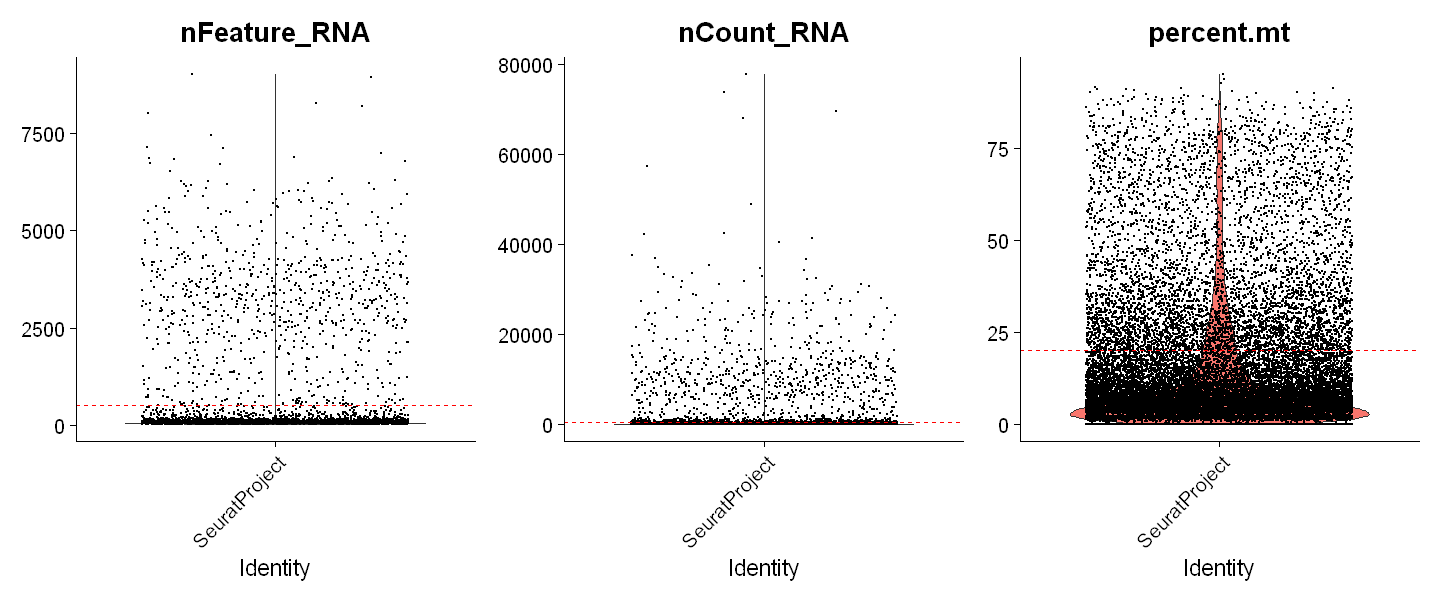

In [13]:
thresholds <- c(500, 500, 20)

plot_with_threshold(seurat_object, 
                    features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), 
                    threshold_list = thresholds)

In [14]:
seurat_object <- filter_seurat_object(seurat_object, 500, 20)
print_seurat_stats(seurat_object)
seurat_object_norm <- NormalizeData(seurat_object, assay = "CMO", normalization.method = "CLR")
seurat_object_demux <- HTODemux(seurat_object_norm, assay = "CMO", positive.quantile = 0.99)
head(seurat_object_demux@meta.data)

Number of cells: 781 
Number of genes: 36601 


Warning message:
"The `slot` argument of `SetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>."
Warning message:
"The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>."
Normalizing across features

As of Seurat v5, we recommend using AggregateExpression to perform pseudo-bulk analysis.
This message is displayed once per session.
Cutoff for Hash18 : 1 reads

Cutoff for Hash19 : 614 reads

Cutoff for Hash23 : 74 reads

Cutoff for Hash24 : 67 reads



,orig.ident,nCount_RNA,nFeature_RNA,nCount_CMO,nFeature_CMO,percent.mt,CMO_maxID,CMO_secondID,CMO_margin,CMO_classification,CMO_classification.global,hash.ID
,<fct>,<dbl>,<int>,<dbl>,<int>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<fct>
AAACCCAAGTATAGAC-1,SeuratProject,7543,2686,2391,4,3.1022140,Hash19,Hash18,0.869702,Hash19,Singlet,Hash19
AAACGAAAGGAACGCT-1,SeuratProject,10527,3140,5110,3,6.7445616,Hash19,Hash23,1.463663,Hash19,Singlet,Hash19
AAACGCTGTTCACCGG-1,SeuratProject,17293,4243,7192,3,1.1449720,Hash19,Hash23,2.131325,Hash19,Singlet,Hash19
AAAGGGCCACTAACGT-1,SeuratProject,3426,1734,4445,3,4.9620549,Hash19,Hash23,1.651337,Hash19,Singlet,Hash19
AAAGGGCGTAGCGCCT-1,SeuratProject,10878,3504,6598,4,4.7986762,Hash19,Hash24,1.704653,Hash19,Singlet,Hash19
AAAGGTAAGTCGCCAC-1,SeuratProject,10272,3515,4443,3,0.3212617,Hash19,Hash24,1.407699,Hash19,Singlet,Hash19


In [15]:
#check how many singlets you have
table(seurat_object_demux$CMO_classification.global)


 Doublet Negative  Singlet 
      83       11      687 

In [16]:
seurat_object <- subset(seurat_object_demux, subset = CMO_classification.global %in% c("Singlet"))
print_seurat_stats(seurat_object)

Number of cells: 687 
Number of genes: 36601 


Warning message:
"Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead."
Warning message:
"Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead."


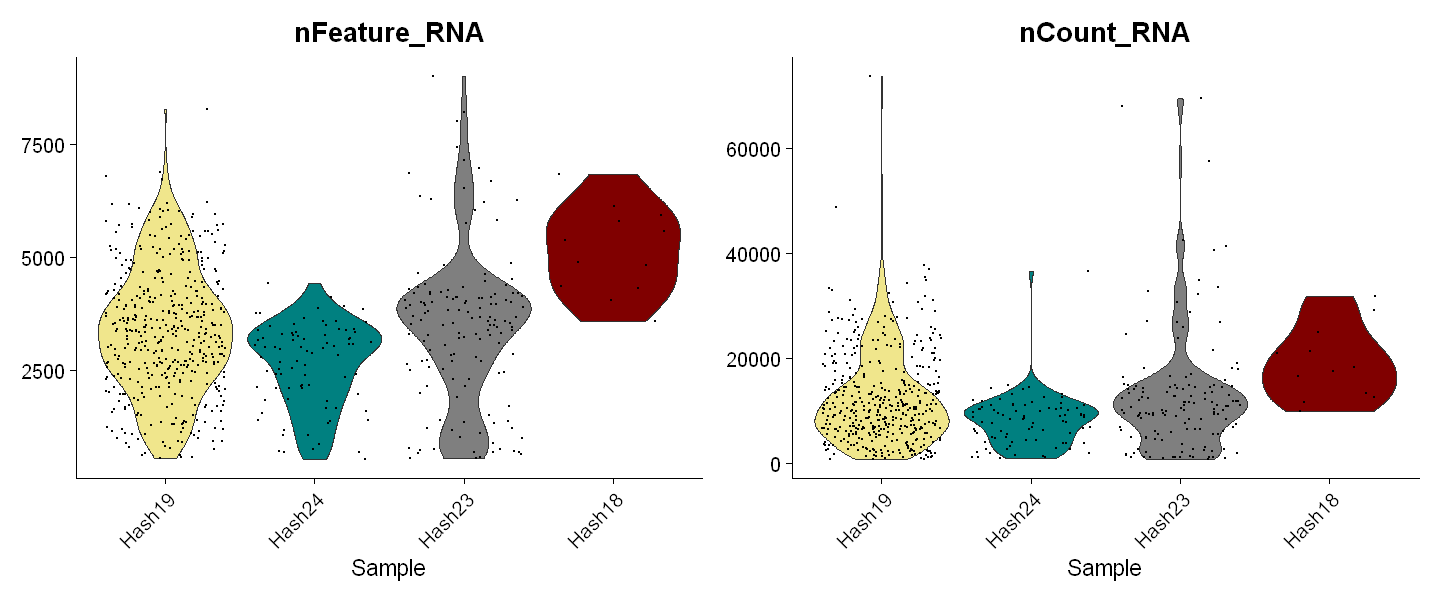

In [17]:
plot_qc_violin(seurat_object)

Warning message:
"Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead."


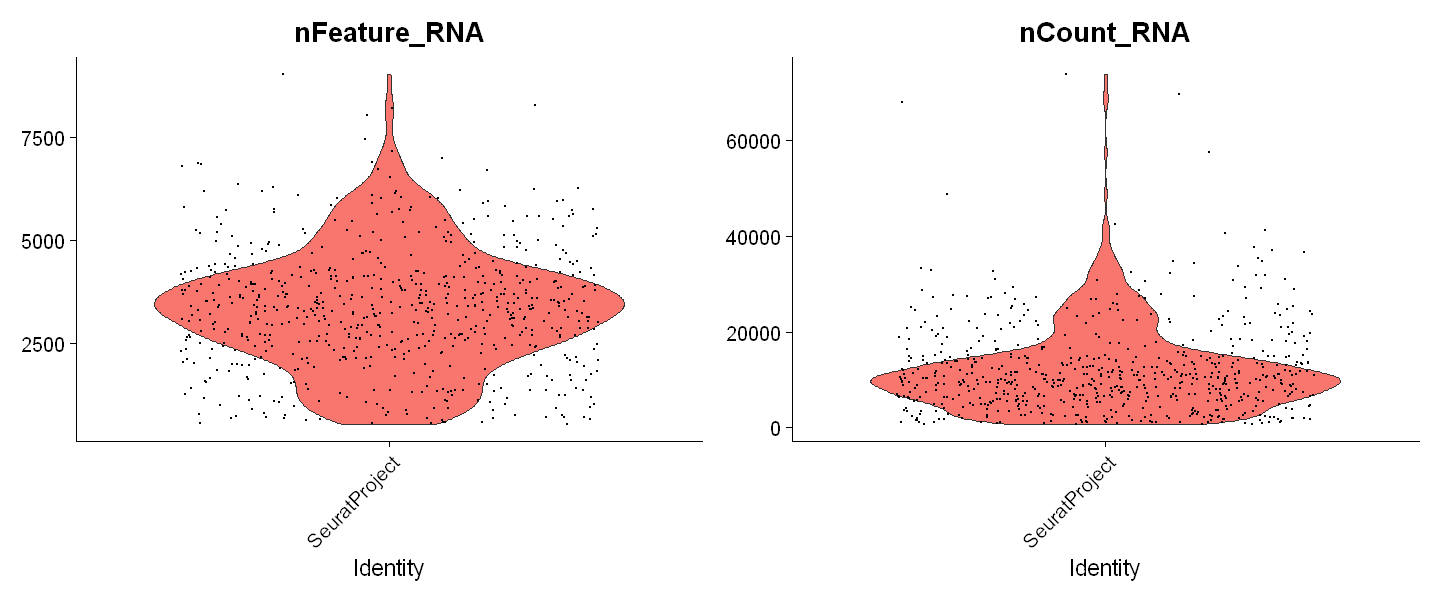

In [18]:
VlnPlot(seurat_object, features = c("nFeature_RNA", "nCount_RNA"), 
        ncol = 2, group.by = "orig.ident", assay = "RNA")


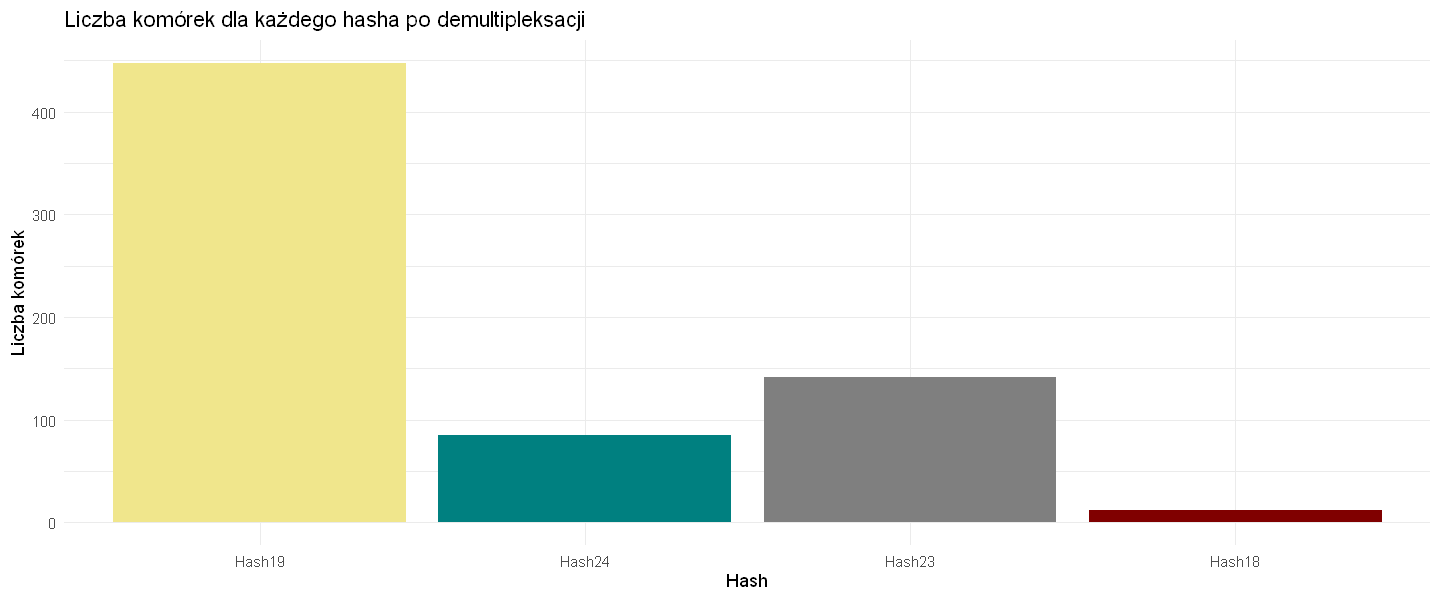

In [19]:
plot_hash_counts(seurat_object)


Normalizing layer: counts

Finding variable features for layer counts

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message in scale_x_log10():
"log-10 transformation introduced infinite values."


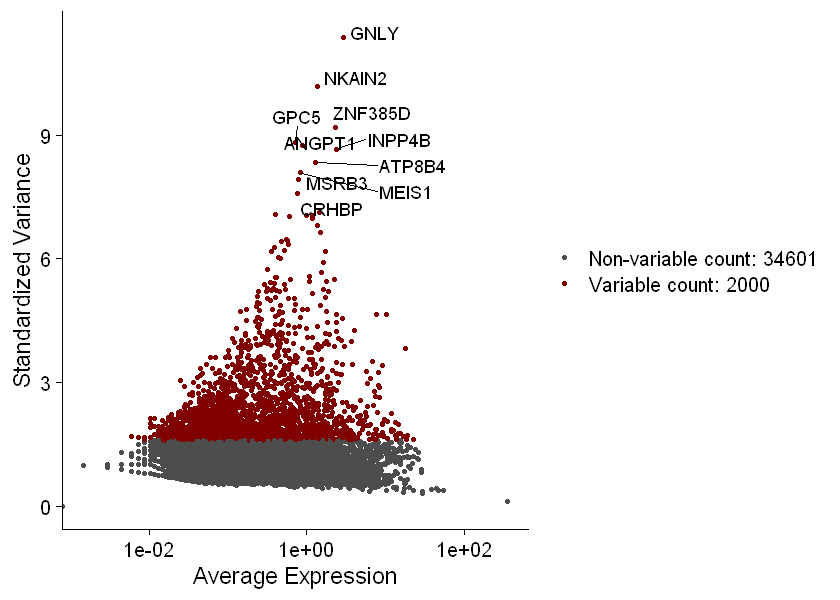

In [20]:
seurat_object <- NormalizeData(seurat_object)
seurat_object <- FindVariableFeatures(seurat_object, selection.method = "vst", nfeatures = 2000)
options(repr.plot.width = 7, repr.plot.height = 5)
# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(seurat_object), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(seurat_object, cols = c("#4D4D4D", "#800000"))
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot2

In [21]:
# scale data 
all.genes <- rownames(seurat_object)
seurat_object <- ScaleData(seurat_object, features = all.genes)

Centering and scaling data matrix



In [ ]:
# Zapisanie obiektu Seurat do pliku RDS
saveRDS(seurat_object, file = "../SAMPLE_OUT/sample3.rds")